In [298]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = "cpu"

CUDA: True


In [379]:
def fibre_propagation(U0, wvl, x, z, refractive_index):
    """
    Propagates an optical field through a fibre

    Parameters:
        U0      : 4D torch tensor (batch, channel, x, y)
        wvl     : float (wavelength of light in meters)
        dx      : float (sampling interval in meters)
        z       : float (propagation distance in meters)

    Returns:
        U1  : the propagated field (same shape as U0)
    """

    nx = U0.shape[0]
    k = 2 * torch.pi / wvl

    dx = torch.abs(x[1] - x[0])
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)

    U_out = torch.zeros(nx, z.shape[0], device=U0.device) + 0j
    U_out[:, 0] = U0 

    absorbing_window = torch.exp(-(x / (40e-6))**20)
    dz = z[1] - z[0]
    
    H = torch.exp(1j * k * dz * torch.sqrt(1 + 0j - (wvl * fx) ** 2))
    for i in range(1, z.shape[0]):
        U_in = U_out[:, i - 1]
        phase_shift = torch.exp(1j * k * dz * refractive_index[:, i - 1]) * absorbing_window
        U1 = torch.fft.fftshift(torch.fft.ifft(torch.fft.fft(torch.fft.ifftshift(U_out[:, i - 1] * phase_shift)) * H))
        U_out[:, i] = U1
        

    return U_out

Text(0, 0.5, 'Y in ,m')

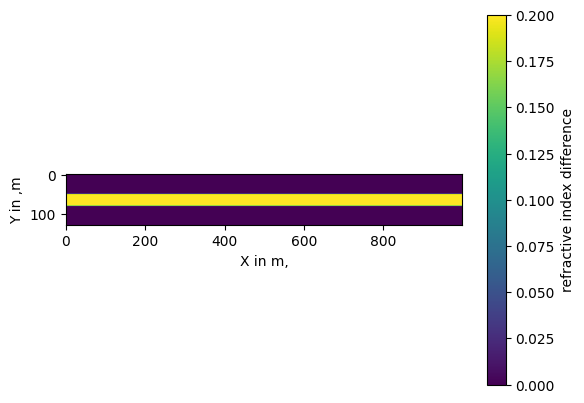

In [380]:
refractive_index = torch.zeros(128, 1000)
wvl = 633e-9

x = torch.linspace(-50e-6, 50e-6, 128)
z = torch.linspace(0e-6, 1000e-6, 200)
refractive_index[50:80, :] = 0.2

plt.imshow(refractive_index.cpu().numpy())
plt.colorbar(label="refractive index difference")
plt.xlabel("X in m,")
plt.ylabel("Y in ,m")

Text(0, 0.5, 'Y in ,m')

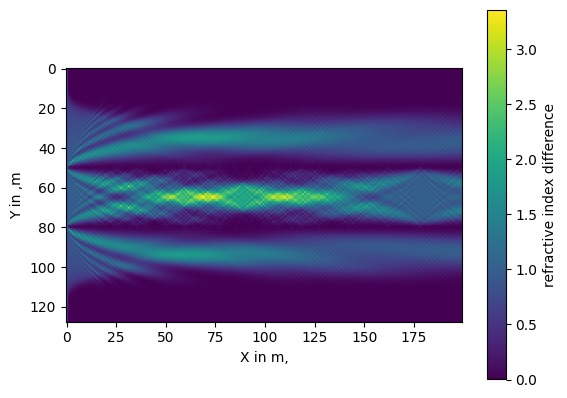

In [381]:
U0 = torch.exp(-x**2 / (2 * 40e-6)**2)
U_prop = fibre_propagation(U0, wvl, x, z, refractive_index)

plt.imshow((torch.abs(U_prop)**2).cpu().numpy())
plt.colorbar(label="refractive index difference")
plt.xlabel("X in m,")
plt.ylabel("Y in ,m")

# Focusing through Fiber

In this section, you will measure a transmission matrix. To do so, launch single 1D peaks into the fiber and record the output. For the inversion of `M`, use `torch.pinverse(M, rcond=1e-7)`.

Determine a complex input field that, when launched through the fiber, produces a single peak at the x-location `x=394 nm`.
The entire spatial domain is in 1D.

In [428]:
def optical_system(U_in):
    return fibre_propagation(U_in, wvl, x, z, refractive_index)[:, -1]

In [429]:
def build_matrix2(N=128):
    M = torch.zeros(N , N) + 0j
    # probe optical system
    m = 0
    for i in range(N):
        X = torch.zeros(N)
        X[i] = 1
        M[:, i] = optical_system(X)

    return M

In [430]:
def build_matrix(K, N=128):
    # input and outputs
    Xs = torch.zeros(N, N) + 0j
    Ys = torch.zeros(N, N) + 0j

    # probe optical system
    for i in range(K):
        X = torch.zeros(N)
        X[i] = 1
        Xs[:,  i] = X
        Ys[:,  i] = optical_system(X)

    # Calculate pseudoinverse of X
    X_pinv = torch.pinverse(Xs, rcond=1e-7)

    # Solve for M
    M = Ys @ X_pinv
    return M

In [431]:
spot = torch.zeros((128,)) + 0j
spot[64:65] = 1

In [432]:
field = (torch.pinverse(M, rcond=1e-7) @ spot)

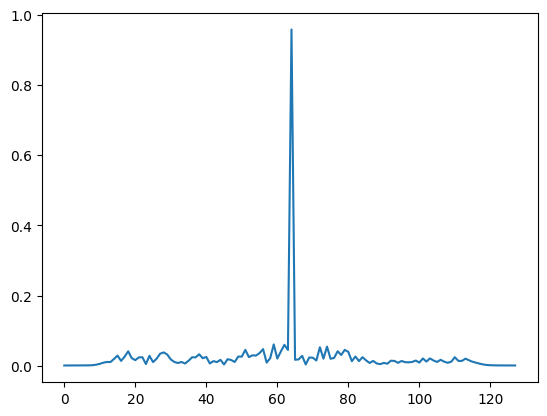

In [433]:
M = build_matrix2(128)
spot_focused = optical_system(field)
plt.plot(torch.abs(spot_focused))